**Colab 6: Recurrent Nets**

As opposed to the networks of the previous weeks, which take as input a single datum, recurrent networks operate on sequences, and process each element of a sequence one at a time.  They do so by updating an internal state, and the big 3 types of recurrent layers update that internal state with different amounts sophistication toward remembering long timescale correlations. A simple RNN's internal state is literally just a fully connected layer; GRU (gated recurrent unit) and LSTM (long short-term memory) add gates which allow control over how the internal state gets updated with each new timestep.  

We'll use these to generate some Shakespeare and classify digits using only a random walk over the pixels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds
import os

tfkl = tf.keras.layers

#Characters of Shakespeare recurreth

Here we'll take a million characters of Shakespeare and train a recurrent net to learn the statistics well enough to generate its own new, never before seen text!

In [3]:
dset = tfds.load('tiny_shakespeare')['train']

In [4]:
# Split the dataset into characters, turn those into indices
dset = dset.map(lambda ex: tf.strings.unicode_split(ex['text'], 'UTF-8'))
# We can grab the whole thing
whole_text = next(iter(dset))
print('Length of dataset:', whole_text.shape)
vocabulary = sorted(set(whole_text.numpy()))
print('Vocabulary:', vocabulary)

Length of dataset: (1003854,)
Vocabulary: [b'\n', b' ', b'!', b'$', b'&', b"'", b',', b'-', b'.', b'3', b':', b';', b'?', b'A', b'B', b'C', b'D', b'E', b'F', b'G', b'H', b'I', b'J', b'K', b'L', b'M', b'N', b'O', b'P', b'Q', b'R', b'S', b'T', b'U', b'V', b'W', b'X', b'Y', b'Z', b'a', b'b', b'c', b'd', b'e', b'f', b'g', b'h', b'i', b'j', b'k', b'l', b'm', b'n', b'o', b'p', b'q', b'r', b's', b't', b'u', b'v', b'w', b'x', b'y', b'z']


In [5]:
# We're going to take an input sequence of characters [0, N] and try to predict characters [1, N+1], for a bunch of sequences
# So make two copies of the string, one character shifted from each other
dset = dset.map(lambda ex: (ex[:-1], ex[1:]))

# This will be the sequence length to train on (and the longest memory the system gets signal for; try changing to something like 4 to see the difference)
sequence_length = 100

# Unbatch the dataset and then rebatch into these pairs of 100 characters, and drop the stragglers
dset = dset.unbatch().batch(sequence_length, drop_remainder=True)

# Let's look at the monster we've created
first_element = next(iter(dset))
print(first_element)

(<tf.Tensor: shape=(100,), dtype=string, numpy=
array([b'F', b'i', b'r', b's', b't', b' ', b'C', b'i', b't', b'i', b'z',
       b'e', b'n', b':', b'\n', b'B', b'e', b'f', b'o', b'r', b'e', b' ',
       b'w', b'e', b' ', b'p', b'r', b'o', b'c', b'e', b'e', b'd', b' ',
       b'a', b'n', b'y', b' ', b'f', b'u', b'r', b't', b'h', b'e', b'r',
       b',', b' ', b'h', b'e', b'a', b'r', b' ', b'm', b'e', b' ', b's',
       b'p', b'e', b'a', b'k', b'.', b'\n', b'\n', b'A', b'l', b'l', b':',
       b'\n', b'S', b'p', b'e', b'a', b'k', b',', b' ', b's', b'p', b'e',
       b'a', b'k', b'.', b'\n', b'\n', b'F', b'i', b'r', b's', b't', b' ',
       b'C', b'i', b't', b'i', b'z', b'e', b'n', b':', b'\n', b'Y', b'o',
       b'u'], dtype=object)>, <tf.Tensor: shape=(100,), dtype=string, numpy=
array([b'i', b'r', b's', b't', b' ', b'C', b'i', b't', b'i', b'z', b'e',
       b'n', b':', b'\n', b'B', b'e', b'f', b'o', b'r', b'e', b' ', b'w',
       b'e', b' ', b'p', b'r', b'o', b'c', b'e', b'e', b'd', b' 

In [8]:
# To make these readable, join the characters
for sequence in first_element:
  print(tf.strings.reduce_join(sequence, axis=-1).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


So given the first sequence as output, one character at a time, we want the network to assign high probabilities to the next character which follows.  

E.g. in this first element, the input to the network will first be 'F'.  This will change the internal state and output probabilities for each possible character in the vocabulary; we want a high probability for the actual next character, 'i'.  

The next input is 'i', which will update the internal state again (which should, eventually, know that the preceding character was 'F'), and now the output of the network should assign a high probability to 'r'.  

Thus these two sequences give 100 calls and responses with which to update the network. 

In [9]:
# We'll need to convert the characters to integers, and then back
intoIDs_layer = tfkl.StringLookup(vocabulary=vocabulary, invert=False, mask_token=None)
back2chars_layer = tfkl.StringLookup(vocabulary=vocabulary, invert=True, mask_token=None)

In [11]:
first_element_ids = intoIDs_layer(first_element[0])
print(first_element_ids)

tf.Tensor(
[19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 15 44 45 54 57 44  2 62 44
  2 55 57 54 42 44 44 43  2 40 53 64  2 45 60 57 59 47 44 57  7  2 47 44
 40 57  2 52 44  2 58 55 44 40 50  9  1  1 14 51 51 11  1 32 55 44 40 50
  7  2 58 55 44 40 50  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11
  1 38 54 60], shape=(100,), dtype=int64)


In [12]:
back2chars_layer(first_element_ids)

<tf.Tensor: shape=(100,), dtype=string, numpy=
array([b'F', b'i', b'r', b's', b't', b' ', b'C', b'i', b't', b'i', b'z',
       b'e', b'n', b':', b'\n', b'B', b'e', b'f', b'o', b'r', b'e', b' ',
       b'w', b'e', b' ', b'p', b'r', b'o', b'c', b'e', b'e', b'd', b' ',
       b'a', b'n', b'y', b' ', b'f', b'u', b'r', b't', b'h', b'e', b'r',
       b',', b' ', b'h', b'e', b'a', b'r', b' ', b'm', b'e', b' ', b's',
       b'p', b'e', b'a', b'k', b'.', b'\n', b'\n', b'A', b'l', b'l', b':',
       b'\n', b'S', b'p', b'e', b'a', b'k', b',', b' ', b's', b'p', b'e',
       b'a', b'k', b'.', b'\n', b'\n', b'F', b'i', b'r', b's', b't', b' ',
       b'C', b'i', b't', b'i', b'z', b'e', b'n', b':', b'\n', b'Y', b'o',
       b'u'], dtype=object)>

In [13]:
# Ok, map the entire dataset to integers, and subtract 1 because it's not 0-indexed for some weird reason
dset_ids = dset.map(lambda a, b: (intoIDs_layer(a)-1, intoIDs_layer(b)-1))

In [26]:
# The magic simplicity -- make the model, which consists of an embedding layer which
# just projects the integers to unique high dimensional vectors (also a bit of magic imo)
# before passing them through a single recurrent layer, which then outputs logits for the vocabulary
vocab_size = len(vocabulary)
embedding_dim = 256
num_recurrent_units = 1024
model = tf.keras.Sequential([
                             tfkl.Input(shape=(None,)),
                             tfkl.Embedding(vocab_size, embedding_dim),
                             tfkl.LSTM(num_recurrent_units, return_sequences=True),
                             tfkl.Dense(vocab_size)
])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         16640     
_________________________________________________________________
lstm (LSTM)                  (None, None, 1024)        5246976   
_________________________________________________________________
dense_2 (Dense)              (None, None, 65)          66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
# What does this output?
in1, out1 = next(iter(dset_ids.batch(1)))
print('Input sequence:', in1)
print('Output sequence:', out1)
prediction = model(in1)
print('Model prediction:', prediction)
loss = tf.keras.losses.sparse_categorical_crossentropy(out1, prediction, from_logits=True)
print('Loss:', loss)

Input sequence: tf.Tensor(
[[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
   1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
  39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
   6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
   0 37 53 59]], shape=(1, 100), dtype=int64)
Output sequence: tf.Tensor(
[[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
  54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
  56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49  6
   1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0
  37 53 59  1]], shape=(1, 100), dtype=int64)
Model prediction: tf.Tensor(
[[[ 0.00244213 -0.00062554 -0.00290528 ...  0.00086083  0.00508059
   -0.00024456]
  [ 0.00615366  0.00140118 -0.00191334 ...  0.00263032 -0.00313211
   -0.00163818]
  [ 0.00959521  0.00353935  0.00181451 ... -0.00567161  0.00034304

In [28]:
# We can compile as before, and just treat this as a classification problem (which is cool that this works under that perspective)

##TODO compile the model just like in the classification tasks, using sparse categorical cross entropy but accepting logits instead of probabilities
model.TODO

bs = 64
# We're going to output generated text along the way
# Feed in the seed_text to start the generation (so feel free to change this)
seed_text = 'Hulk smasheth'
# Then generate this many characters
desired_length = 400

# These are just the epochs to stop and output generated text
epoch_outputs = [0, 1, 3, 7, 15]
num_epochs_series = np.subtract(epoch_outputs[1:], epoch_outputs[:-1])

def generate_text():
  # This is a pretty lazy way to generate the text -- we're going to feed in the seed text, generate a character, append it, and start over again
  generated_text = intoIDs_layer(tf.strings.unicode_split(seed_text, 'UTF-8'))-1  # make the ids 0-indexed
  for _ in range(desired_length):
    prediction_logits = model(generated_text[tf.newaxis])[0]
    generated_text = tf.concat([generated_text, tf.random.categorical(prediction_logits, 1, dtype=tf.int64)[-1]], -1)  # the 1 is the number of samples
  return generated_text

print(f'Epoch 0, generated text:\n')
generated_text = generate_text()
print(tf.strings.reduce_join(back2chars_layer(generated_text+1), axis=-1).numpy().decode('utf-8'))
print()

for block_id, num_epochs in enumerate(num_epochs_series):
  model.fit(dset_ids.shuffle(1000).batch(bs), epochs=num_epochs)
  print(f'Epoch {epoch_outputs[block_id+1]}, generated text:\n')
  print(tf.strings.reduce_join(back2chars_layer(generate_text()+1), axis=-1).numpy().decode('utf-8'))
  print()

Epoch 0, generated text:

Hulk smashethXhHnOWgm-
mql-QvYwcQ;dF',V
KqBNTlyS$yr!Mwo:d-bcQXjRj:S&
SDTloDd-IXcCEJIQKdiA-wqaqhHixCOqMqocw.BJPmbNgfkqMw!!Tpu!YKVjgYBqsvBKbUlcLnF dhFUC,RIm vzVFSqsNqN:yq?lxcBVFGGknoHvW3Jf;;gEmzws
M$:Q.J&!tiygh-$k&ARbMbEAOp3GLkaR.bjcgUY&ITakINB QUSk'MYmdShUQ,.fOO$qgdC $lI:EZuC
$gGJzjYWnqkEgh!CYDtcUZoHG$'
ND.Ty&C?rO- pj'zOWUoi$eb?P:LU3ty$wd,XS&fNw;SyS
HP3HgeR:QPozhnLgOQ-,B$q$X.,Zn-o3pGFTTgOuvyPgxVjFykIPp'EXNF'nFR

157/157 [==============================] - 7s 41ms/step - loss: 2.9062 - accuracy: 0.2376
Epoch 1, generated text:

Hulk smasheth inguraed yoind hitr boligtounce'd woow unow heth fullcheris qudak-of ine hels.

EOMI ItSI
LEOE
 rmay faut wivithet tryour, mind masisem fastes of thekeac, ondiss nos mur andeen novend ay hatlof be ch jond? dkerseird sou ferne touthef duey dor bl bkesde the hed.

Afsor. Culorterighe sillll, satheof thagl phaik himacane,.

ALUCMors thirs,
I Whave bolp ourde qo ofis nou, wratl:
Ya bea
urrby houk! di

Epoch 1/2
157/157 [=========

In [30]:
# Let's turn up the temperature a bit: since the outputs are logit predictions 
# over the vocabulary, we can divide them by a temperature-like parameter
# When it's large, the distribution over outputs becomes more uniform
# When it's small, the outputs become more conservative, picking out only the most
# probable prediction as T->0
seed_text = 'Hulk smasheth'
desired_length = 800

for temperature in [0.25, 0.5, 1, 2, 4]:
  generated_text = ## TODO take the same generation procedure, but scale the logits by temperature before sampling.  
  print(f'**********Temperature = {temperature}**********\n')
  print(tf.strings.reduce_join(back2chars_layer(generated_text+1), axis=-1).numpy().decode('utf-8'))
  print()

**********Temperature = 0.25**********

Hulk smasheth and the duke of me and heart
To see the statue of the duke of York.

LUCIO:
I shall be the cause of the man of her bed,
And therefore I say, and therefore have heard
As the duke of any of the duke of his
that will be a present and one and hanging
That the duke of the truth of his head,
And therefore I say, and say 'tis the noble
Than any thing is not the duke of York,
And therefore I have a happy that had
To have the sun to the duke of many a
man of her beauty of the deed of her
As the duke of many of the deed of her brother.

Provost:
I think there is the sun shall be so one
As the prince that we have done to hell me
To her father too much a thousand of him
And have made me as a present and his son:
I have seen the sun and the duke of his head.

DUKE VINCENTIO:
Master is the news in his 

**********Temperature = 0.5**********

Hulk smasheth your son at the state and make thee
And seem to her head and will not her seems,
And yet the

# Part 2: Classifying MNIST with a random walk over the pixels

In [31]:
# Download MNIST
dset = tfds.load('mnist')
dset_train = dset['train'].map(lambda ex: (tf.image.convert_image_dtype(ex['image'], tf.float32), ex['label']))
dset_test = dset['test'].map(lambda ex: (tf.image.convert_image_dtype(ex['image'], tf.float32), ex['label']))

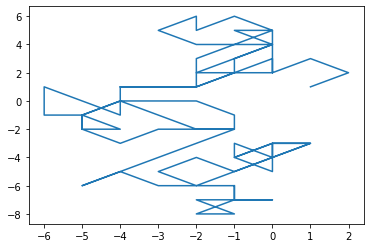

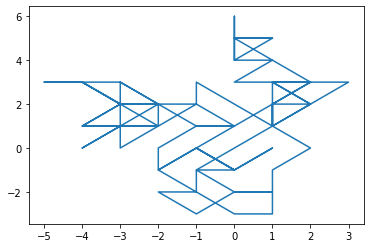

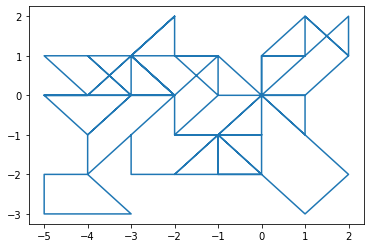

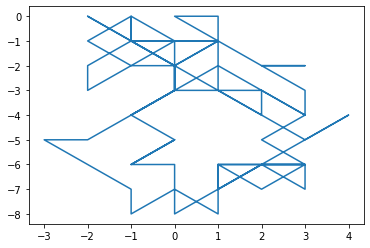

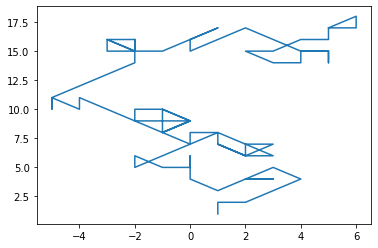

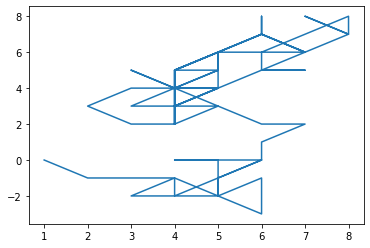

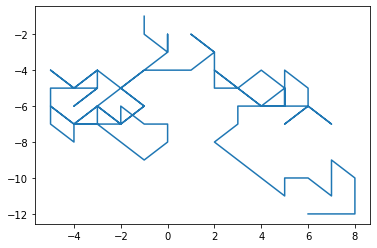

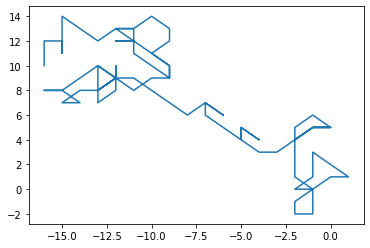

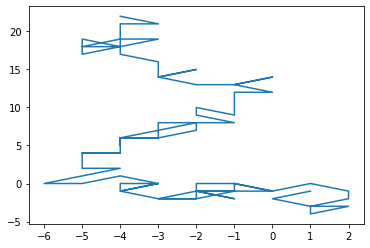

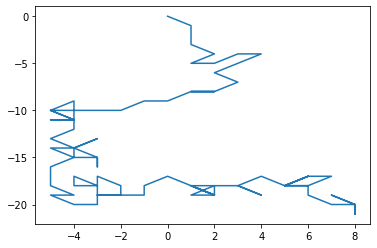

In [32]:
# Let's make some quick and dirty random walks
# Make a 2D random walk by generating random steps and cumulative summing (np.cumsum), then tf.gather the pixels and pair them with the xy coordinates, and the deltax, deltay
for _ in range(10):
  half_step_size = 1
  num_steps = 100
  steps = # TODO generate random 2D steps from a uniform distribution over integers from -half_step_size to +half_step_size
  positions = # TODO use numpy.cumsum to sum the steps and get a time series of positions
  plt.plot(positions[:, 0], positions[:, 1])
  plt.show()

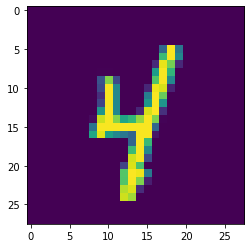

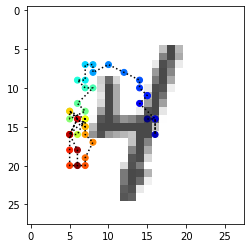

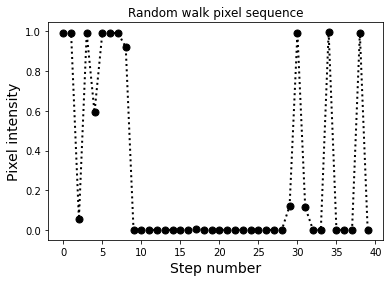

In [36]:
half_step_size = 2  # in pixels
num_steps = 40
ex = next(iter(dset_train))
image = ex[0][..., 0]
# Reproduce the functionality in tensorflow so that we know it can be compiled and run quickly
steps = tf.random.uniform((num_steps, 2), minval=-half_step_size, maxval=half_step_size+1, dtype=tf.int32)
positions = tf.cumsum(steps, axis=0)+tf.constant([13, 13])
positions = tf.clip_by_value(positions, 0, 27)  # We don't want to leave the image
pixels = tf.gather_nd(image, positions)
plt.imshow(image)
plt.show()
plt.subplot(aspect='equal')
plt.imshow(image, vmin=0, vmax=1.4, cmap='binary')
plt.scatter(positions[:, 0], positions[:, 1], c=np.linspace(0, 1, num_steps), cmap='jet')
plt.plot(positions[:, 0], positions[:, 1], 'k:')
plt.xlim(-0.5, 27.5)
plt.ylim(27.5, -0.5)
plt.show()
plt.plot(pixels, 'ko:', markersize=7, lw=2.)
plt.title('Random walk pixel sequence')
plt.xlabel('Step number', fontsize=14)
plt.ylabel('Pixel intensity', fontsize=14)
plt.show()

In [37]:
# Ok, apply this to the dataset, so that each image is turned into a sequence of 5D points (the pixel intensity, the 2D step direction, and the 2D position in the image)
half_step_size = 2
num_steps = 40

@tf.function
def _rand_walk_image(image, label):
  steps = tf.random.uniform((num_steps, 2), minval=-half_step_size, maxval=half_step_size+1, dtype=tf.int32)
  positions = tf.cumsum(steps, axis=0)+tf.constant([13, 13])
  positions = tf.clip_by_value(positions, 0, 27) 
  pixels = tf.gather_nd(image, positions)
  pixel_walk = tf.concat([pixels, tf.cast(steps, tf.float32), tf.cast(positions, tf.float32)/28.], -1)  # Divide by the size of the image to make the scale of the position inputs O(1)
  return pixel_walk, label

dset_train_walk = dset_train.map(_rand_walk_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dset_test_walk = dset_test.map(_rand_walk_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

example = next(iter(dset_train_walk))[0]
print(example)

tf.Tensor(
[[ 0.         -1.          1.          0.42857143  0.5       ]
 [ 0.9960785  -1.          2.          0.39285713  0.5714286 ]
 [ 0.97647065 -1.          0.          0.35714287  0.5714286 ]
 [ 0.          1.         -2.          0.39285713  0.5       ]
 [ 0.          0.         -2.          0.39285713  0.42857143]
 [ 0.10588236  2.          2.          0.4642857   0.5       ]
 [ 0.9960785  -1.          2.          0.42857143  0.5714286 ]
 [ 0.10588236  1.         -2.          0.4642857   0.5       ]
 [ 0.8078432   1.          2.          0.5         0.5714286 ]
 [ 0.          1.          2.          0.53571427  0.64285713]
 [ 0.          1.          0.          0.5714286   0.64285713]
 [ 0.          0.         -1.          0.5714286   0.60714287]
 [ 0.          1.          2.          0.60714287  0.6785714 ]
 [ 0.          2.          2.          0.6785714   0.75      ]
 [ 0.          1.         -2.          0.71428573  0.6785714 ]
 [ 0.          2.          0.          0.785

In [38]:
bs = 64
recurrent_layer = tfkl.LSTM
num_recurrent_layers = 7  # This is probably overkill so feel free to try less
units_per_recurrent_layer = 128
num_epochs = 50  # You can stop earlier if this takes too long

layers = [tfkl.Input((None, 5))]
for _ in range(num_recurrent_layers-1):
  layers+= [recurrent_layer(units_per_recurrent_layer, return_sequences=True)]
layers+= [recurrent_layer(units_per_recurrent_layer)]
layers+= [tfkl.Dense(128, 'relu'), tfkl.Dense(10, 'softmax')]

classifier_net = tf.keras.Sequential(layers)
classifier_net.compile(tf.keras.optimizers.Adam(3e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
classifier_net.fit(dset_train_walk.shuffle(10_000).batch(bs), epochs=num_epochs)
res = classifier_net.evaluate(dset_test_walk.batch(bs))

Epoch 1/50
938/938 [==============================] - 20s 17ms/step - loss: 2.2060 - accuracy: 0.1817
Epoch 2/50
938/938 [==============================] - 15s 16ms/step - loss: 2.1065 - accuracy: 0.2262
Epoch 3/50
938/938 [==============================] - 15s 16ms/step - loss: 2.0257 - accuracy: 0.2562
Epoch 4/50
938/938 [==============================] - 15s 16ms/step - loss: 1.9683 - accuracy: 0.2790
Epoch 5/50
938/938 [==============================] - 15s 16ms/step - loss: 1.9093 - accuracy: 0.3012
Epoch 6/50
938/938 [==============================] - 15s 16ms/step - loss: 1.8479 - accuracy: 0.3259
Epoch 7/50
938/938 [==============================] - 15s 16ms/step - loss: 1.7635 - accuracy: 0.3579
Epoch 8/50
938/938 [==============================] - 15s 16ms/step - loss: 1.6925 - accuracy: 0.3880
Epoch 9/50
938/938 [==============================] - 15s 16ms/step - loss: 1.6314 - accuracy: 0.4091
Epoch 10/50
938/938 [==============================] - 15s 16ms/step - loss: 1.568

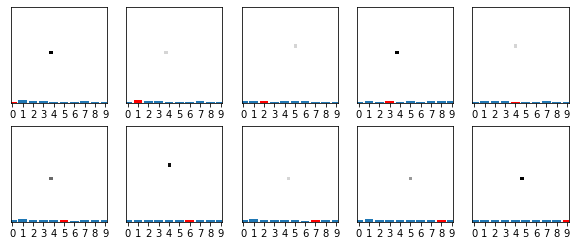

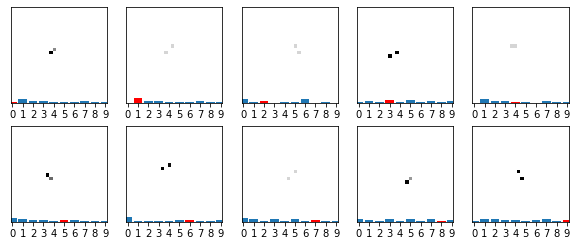

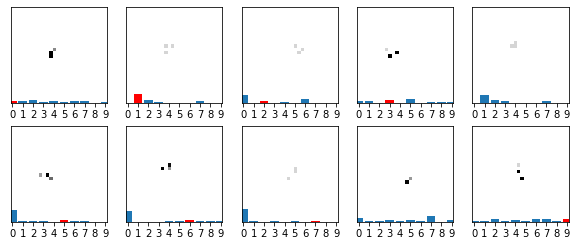

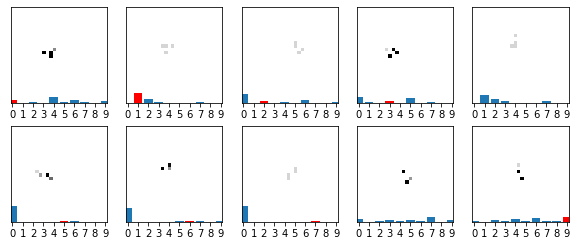

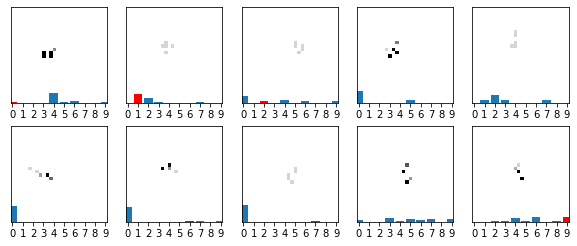

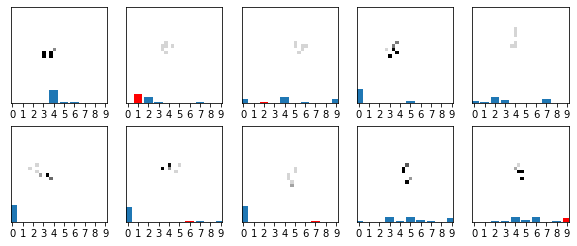

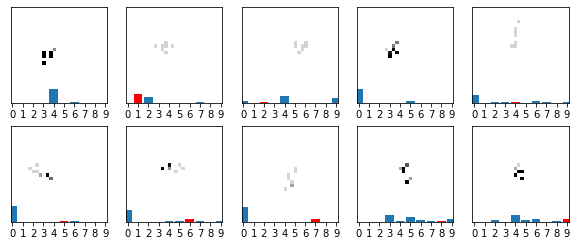

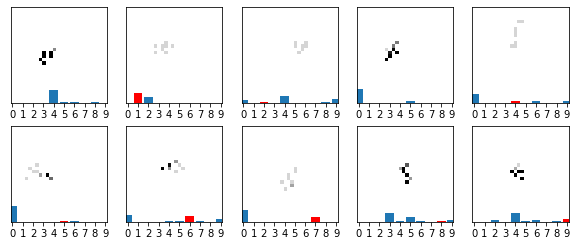

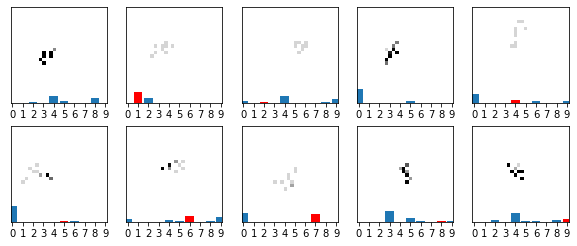

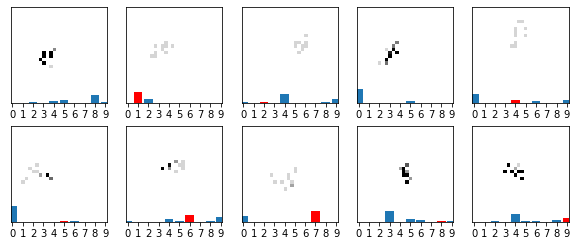

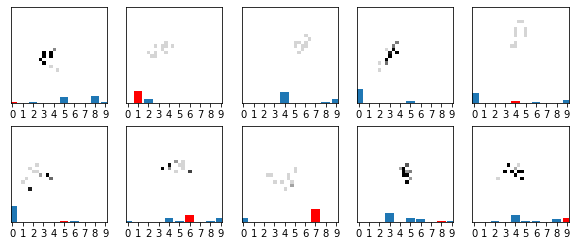

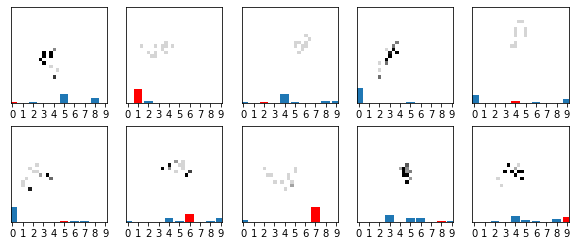

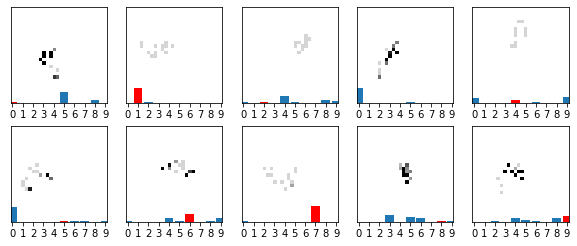

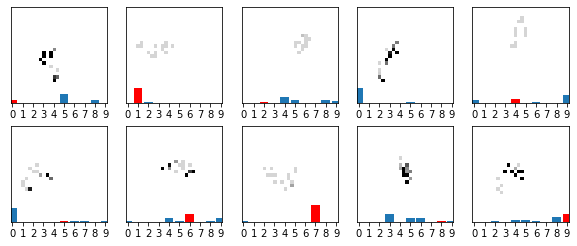

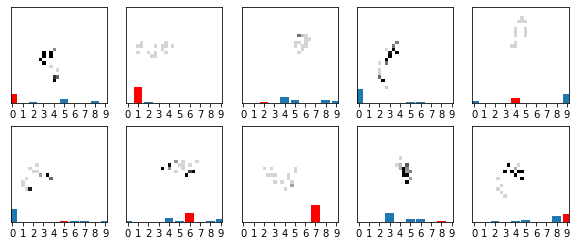

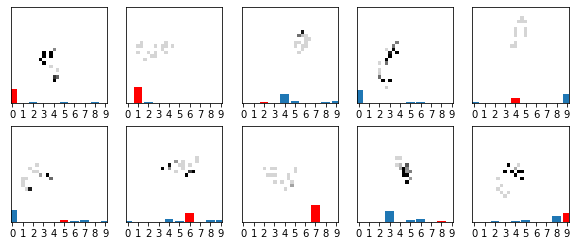

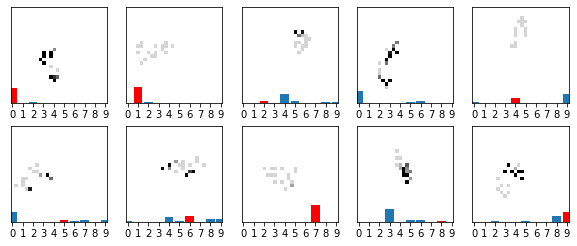

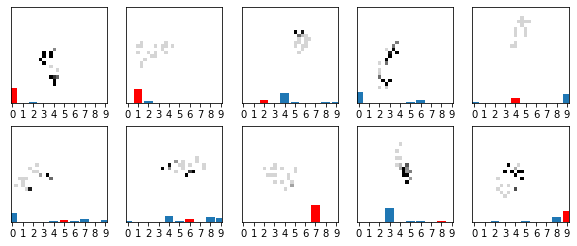

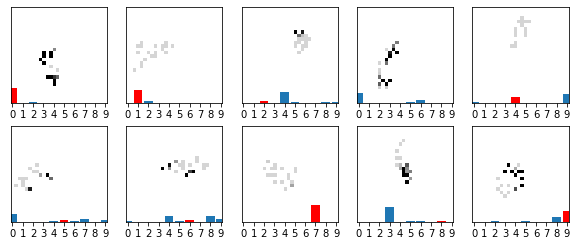

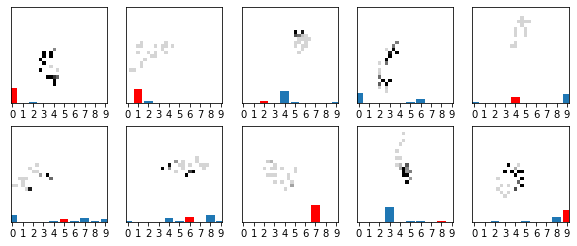

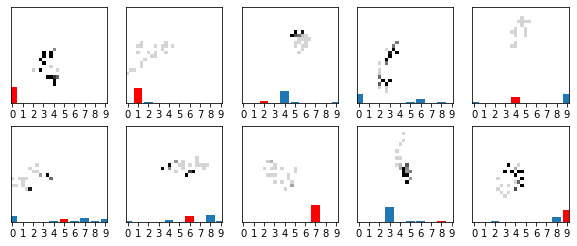

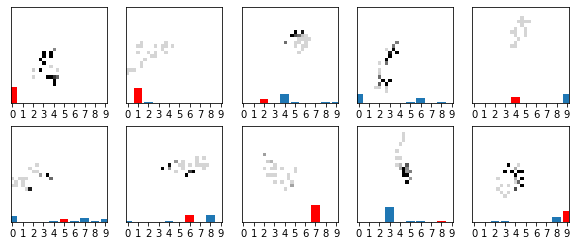

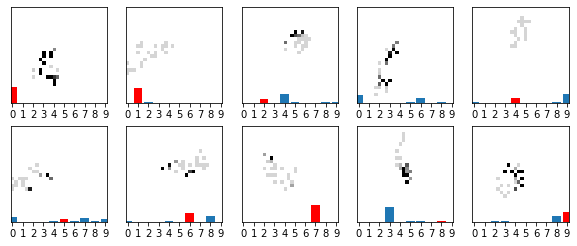

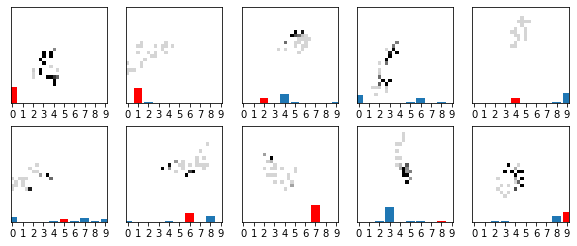

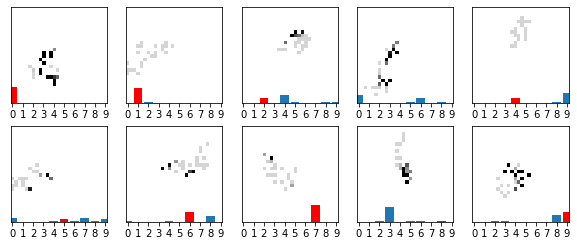

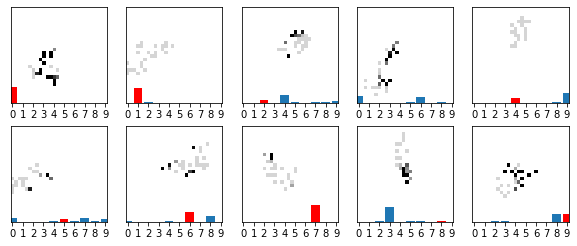

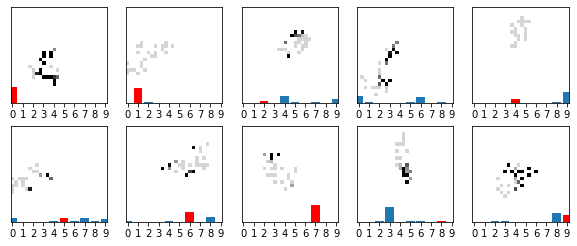

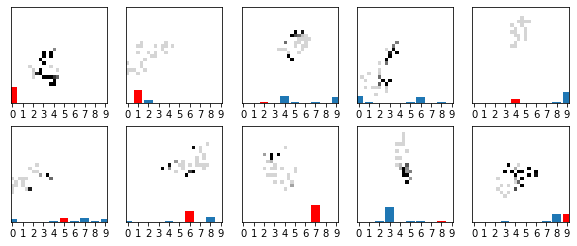

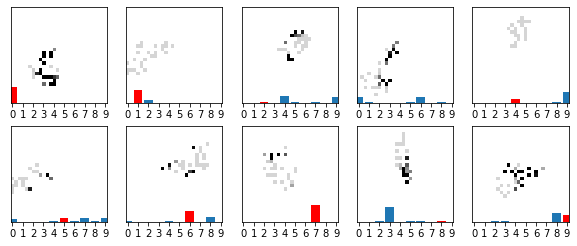

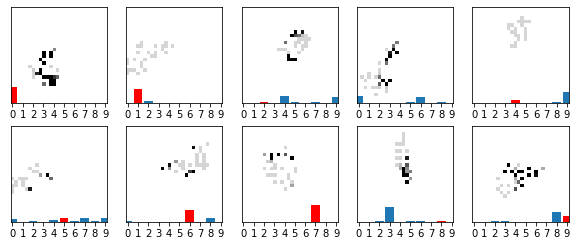

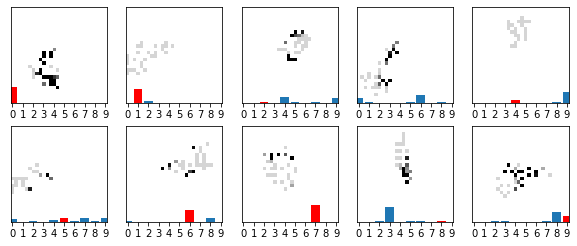

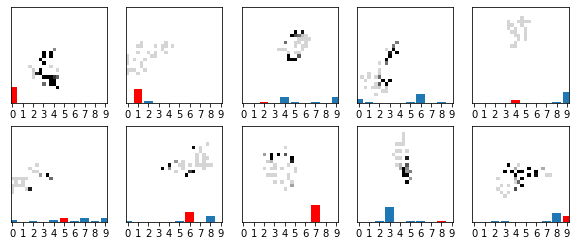

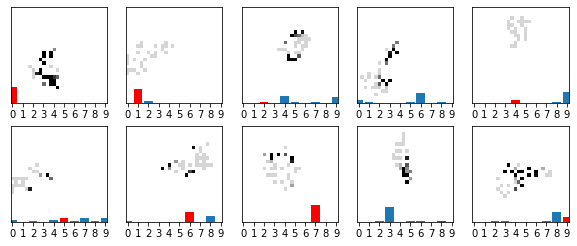

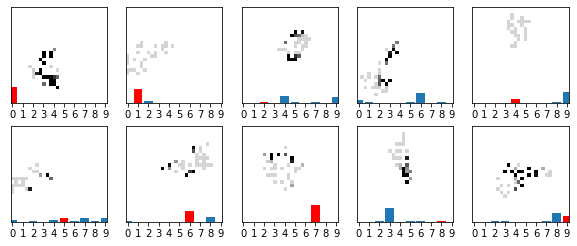

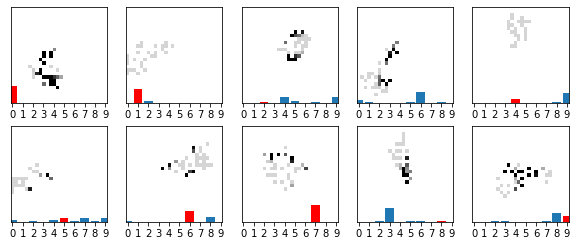

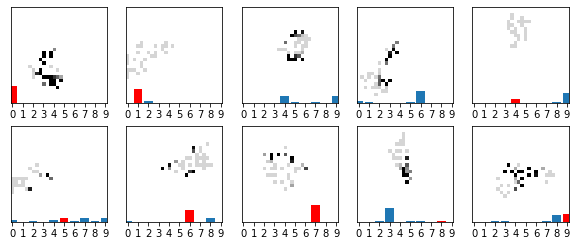

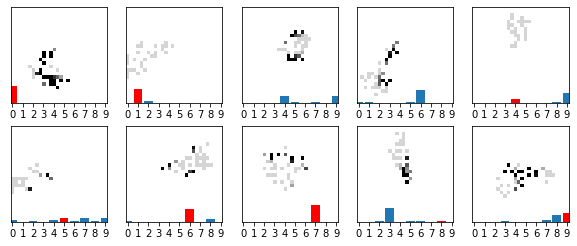

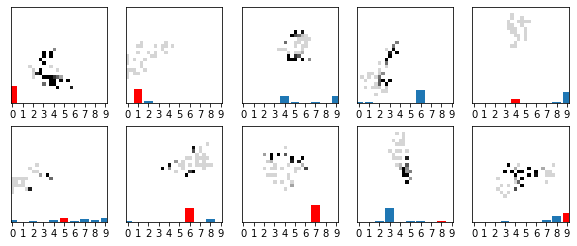

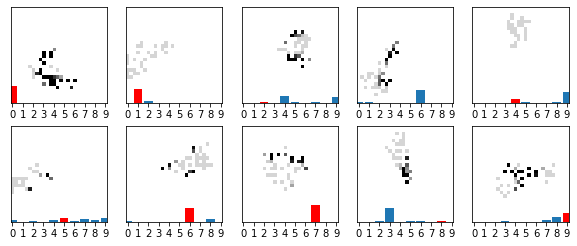

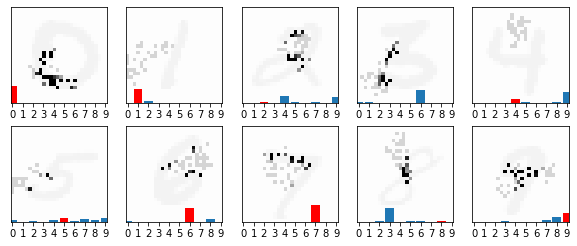

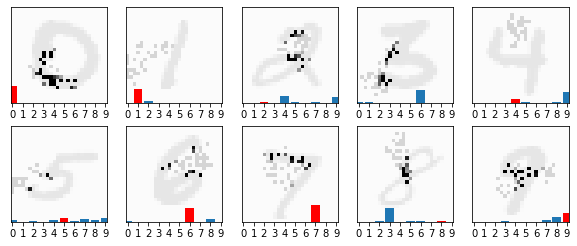

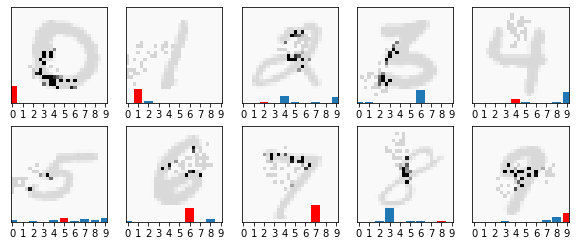

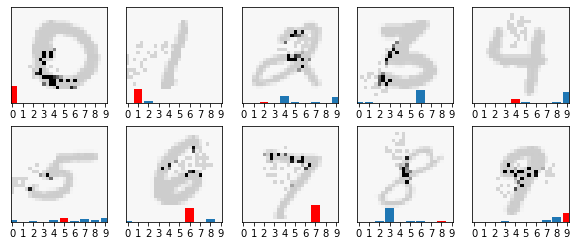

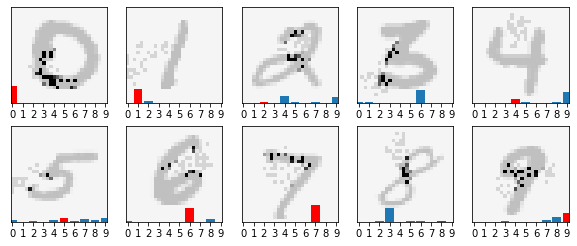

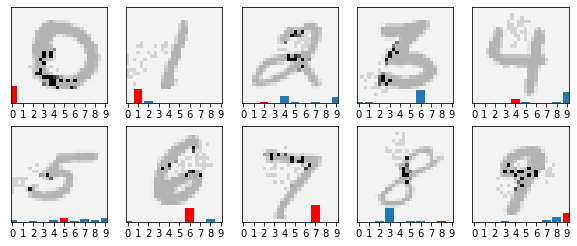

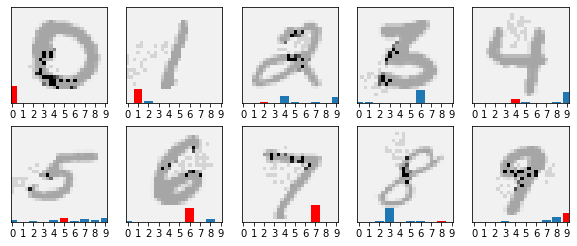

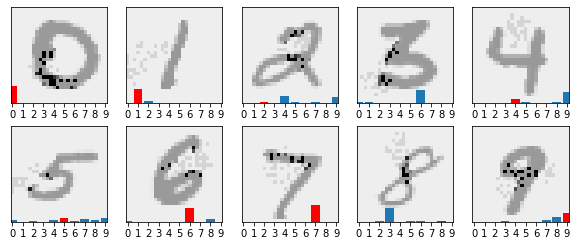

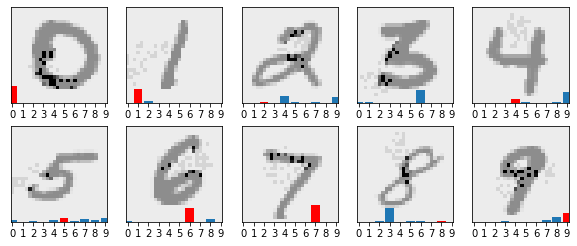

In [42]:
# Let's see it in action!
# Take the network and get the intermediate outputs, by feeding in the sequences step by step
inches_per_subplot_subplot = 2
bar_height_scaling = 5
bar_width = 2.5
masked_pixel_value = -0.2

images = next(iter(dset_test.batch(128)))[0]
walks, labels = next(iter(dset_test_walk.batch(128)))  ## Walks is [pixels, steps, positions]
# Grab the digits 0-9
inds = [tf.where(labels==ind)[0, 0].numpy() for ind in range(10)]

images = tf.gather(images, inds)
walks = tf.gather(walks, inds)
labels = tf.gather(labels, inds)

pixels, steps, positions = tf.split(walks, [1, 2, 2], axis=-1)
positions *= 28.  # To put the pixel positions back into actual pixel coordinates
positions = tf.cast(positions, tf.int32)

grid_xx, grid_yy = tf.meshgrid(tf.range(28), tf.range(28))
grid_xy = tf.stack([grid_xx, grid_yy], -1)
# Kind of a confusing way to get the pixel masks, but the quickest that I could think of
tiled_grid = tf.tile(tf.expand_dims(grid_xy, -1), [1, 1, 1, positions.shape[1]])
tiled_grid = tf.transpose(tiled_grid, [0, 1, 3, 2])

for step_ind in range(1, num_steps):
  predictions = classifier_net(walks[:, :step_ind])
  plt.figure(figsize=(5*inches_per_subplot_subplot, 2*inches_per_subplot_subplot))
  for img_ind in range(10):
    plt.subplot(2, 5, img_ind+1, aspect='equal')
    tiled_positions = tf.reshape(positions[img_ind], [1, 1, -1, 2])
    on_pix = tf.where(tf.reduce_any(tf.reduce_all(tiled_grid[:, :, :step_ind] == tiled_positions[:, :, :step_ind], -1), -1), images[img_ind, ..., 0], masked_pixel_value)
    plt.imshow(on_pix, vmin=masked_pixel_value, vmax=1., cmap='binary')
    plt.bar(np.linspace(0, 27, 10), -predictions[img_ind]*bar_height_scaling, width=bar_width, bottom=27.5)
    plt.bar(np.linspace(0, 27, 10)[labels[img_ind]], (-predictions[img_ind]*bar_height_scaling)[labels[img_ind]], width=bar_width, bottom=27.5, color='r')
    plt.xlim(-0.5, 27.5)
    plt.ylim(27.5, -0.5)
    plt.xticks(np.linspace(0, 27, 10), range(10))
    plt.yticks([])
  plt.show()

# Make a little fade in progression of the actual image
num_fade_transition_steps = 20

for finishing_step in range(1, num_fade_transition_steps//2):
  step_ind += 1
  plt.figure(figsize=(5*inches_per_subplot, 2*inches_per_subplot))
  for img_ind in range(10):
    plt.subplot(2, 5, img_ind+1, aspect='equal')
    tiled_positions = tf.reshape(positions[img_ind], [1, 1, -1, 2])
    on_pix = tf.where(tf.reduce_any(tf.reduce_all(tiled_grid == tiled_positions, -1), -1), images[img_ind, ..., 0], masked_pixel_value)

    plt.imshow(on_pix*float(num_fade_transition_steps-finishing_step)/float(num_fade_transition_steps) + float(finishing_step)/float(num_fade_transition_steps)*images[img_ind, ..., 0], vmin=masked_pixel_value, vmax=1., cmap='binary')
    plt.bar(np.linspace(0, 27, 10), -predictions[img_ind]*bar_height_scaling, width=bar_width, bottom=27.5)
    plt.bar(np.linspace(0, 27, 10)[labels[img_ind]], (-predictions[img_ind]*bar_height_scaling)[labels[img_ind]], width=bar_width, bottom=27.5, color='r')
    plt.xlim(-0.5, 27.5)
    plt.ylim(27.5, -0.5)
    plt.xticks(np.linspace(0, 27, 10), range(10))
    plt.yticks([])
  plt.show()